# Exploratory Data Analysis

In [102]:
%matplotlib inline
from bs4 import BeautifulSoup
# import urllib2
from urllib.request import urlopen
import urllib
import json
import csv
import time
import pickle
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [103]:
funding_data_df=pd.read_csv("funding.csv")
funding_data_df.fillna('', inplace=True)
funding_data_df = funding_data_df.replace(['Unknown'], [''])
funding_data_df.head()

,Description,Market,Names,No_Stage_Amount,No_Stage_Date,Pitch,Seed_Amount,Seed_Date,Series_A_Amount,Series_A_Date,Series_B_Amount,Series_B_Date,Series_C_Amount,Series_C_Date,Series_D_Amount,Series_D_Date,Stage
0,,Cable,Epic-Sciences,,,,,,,,"$13,000,000","Nov 13, 2012","$30,000,000","Jul 30, 2014",,,Series C
1,,All Students,Apreso-Classroom,,,,,,,,"$15,000,000","Oct 14, 2008",,,,,Series B
2,Visualead (视觉码) creates better interactions be...,Bridging Online and Offline,Visualead,,,Effective and Secure Offline to Mobile experie...,"$750,000","Mar 25, 2012","$1,600,000","Aug 15, 2013",,"Jan 20, 2015",,,,,Series B
3,,Food Processing,Onshift,"$7,000,000","Feb 3, 2014",,,,,,"$3,000,000","Feb 2, 2012",,,,,Series C
4,,-,Xendex-Holding,,,,,,,"Jun 25, 2008","$3,500,000","Nov 30, 2009",,,,,Series A


In [104]:
def finding_statistics(funding):
    amounts = filter(lambda x: x!='', list(funding))
    amounts = list(map(lambda x: int(x[1:].replace(',', '')), amounts))
    return np.mean(amounts), np.std(amounts), max(amounts), min(amounts)
    
(finding_statistics(funding_data_df.Series_A_Amount), finding_statistics(funding_data_df.Series_B_Amount), finding_statistics(funding_data_df.Series_C_Amount), finding_statistics(funding_data_df.Series_D_Amount))

((5974206.060736196, 5542666.930985924, 76000000, 56300),
 (11512685.208875287, 9372374.310302174, 85000000, 88900),
 (16317432.270710059, 12946385.665555209, 99000000, 45),
 (16693317.08040201, 12485770.709775113, 75000000, 100000))

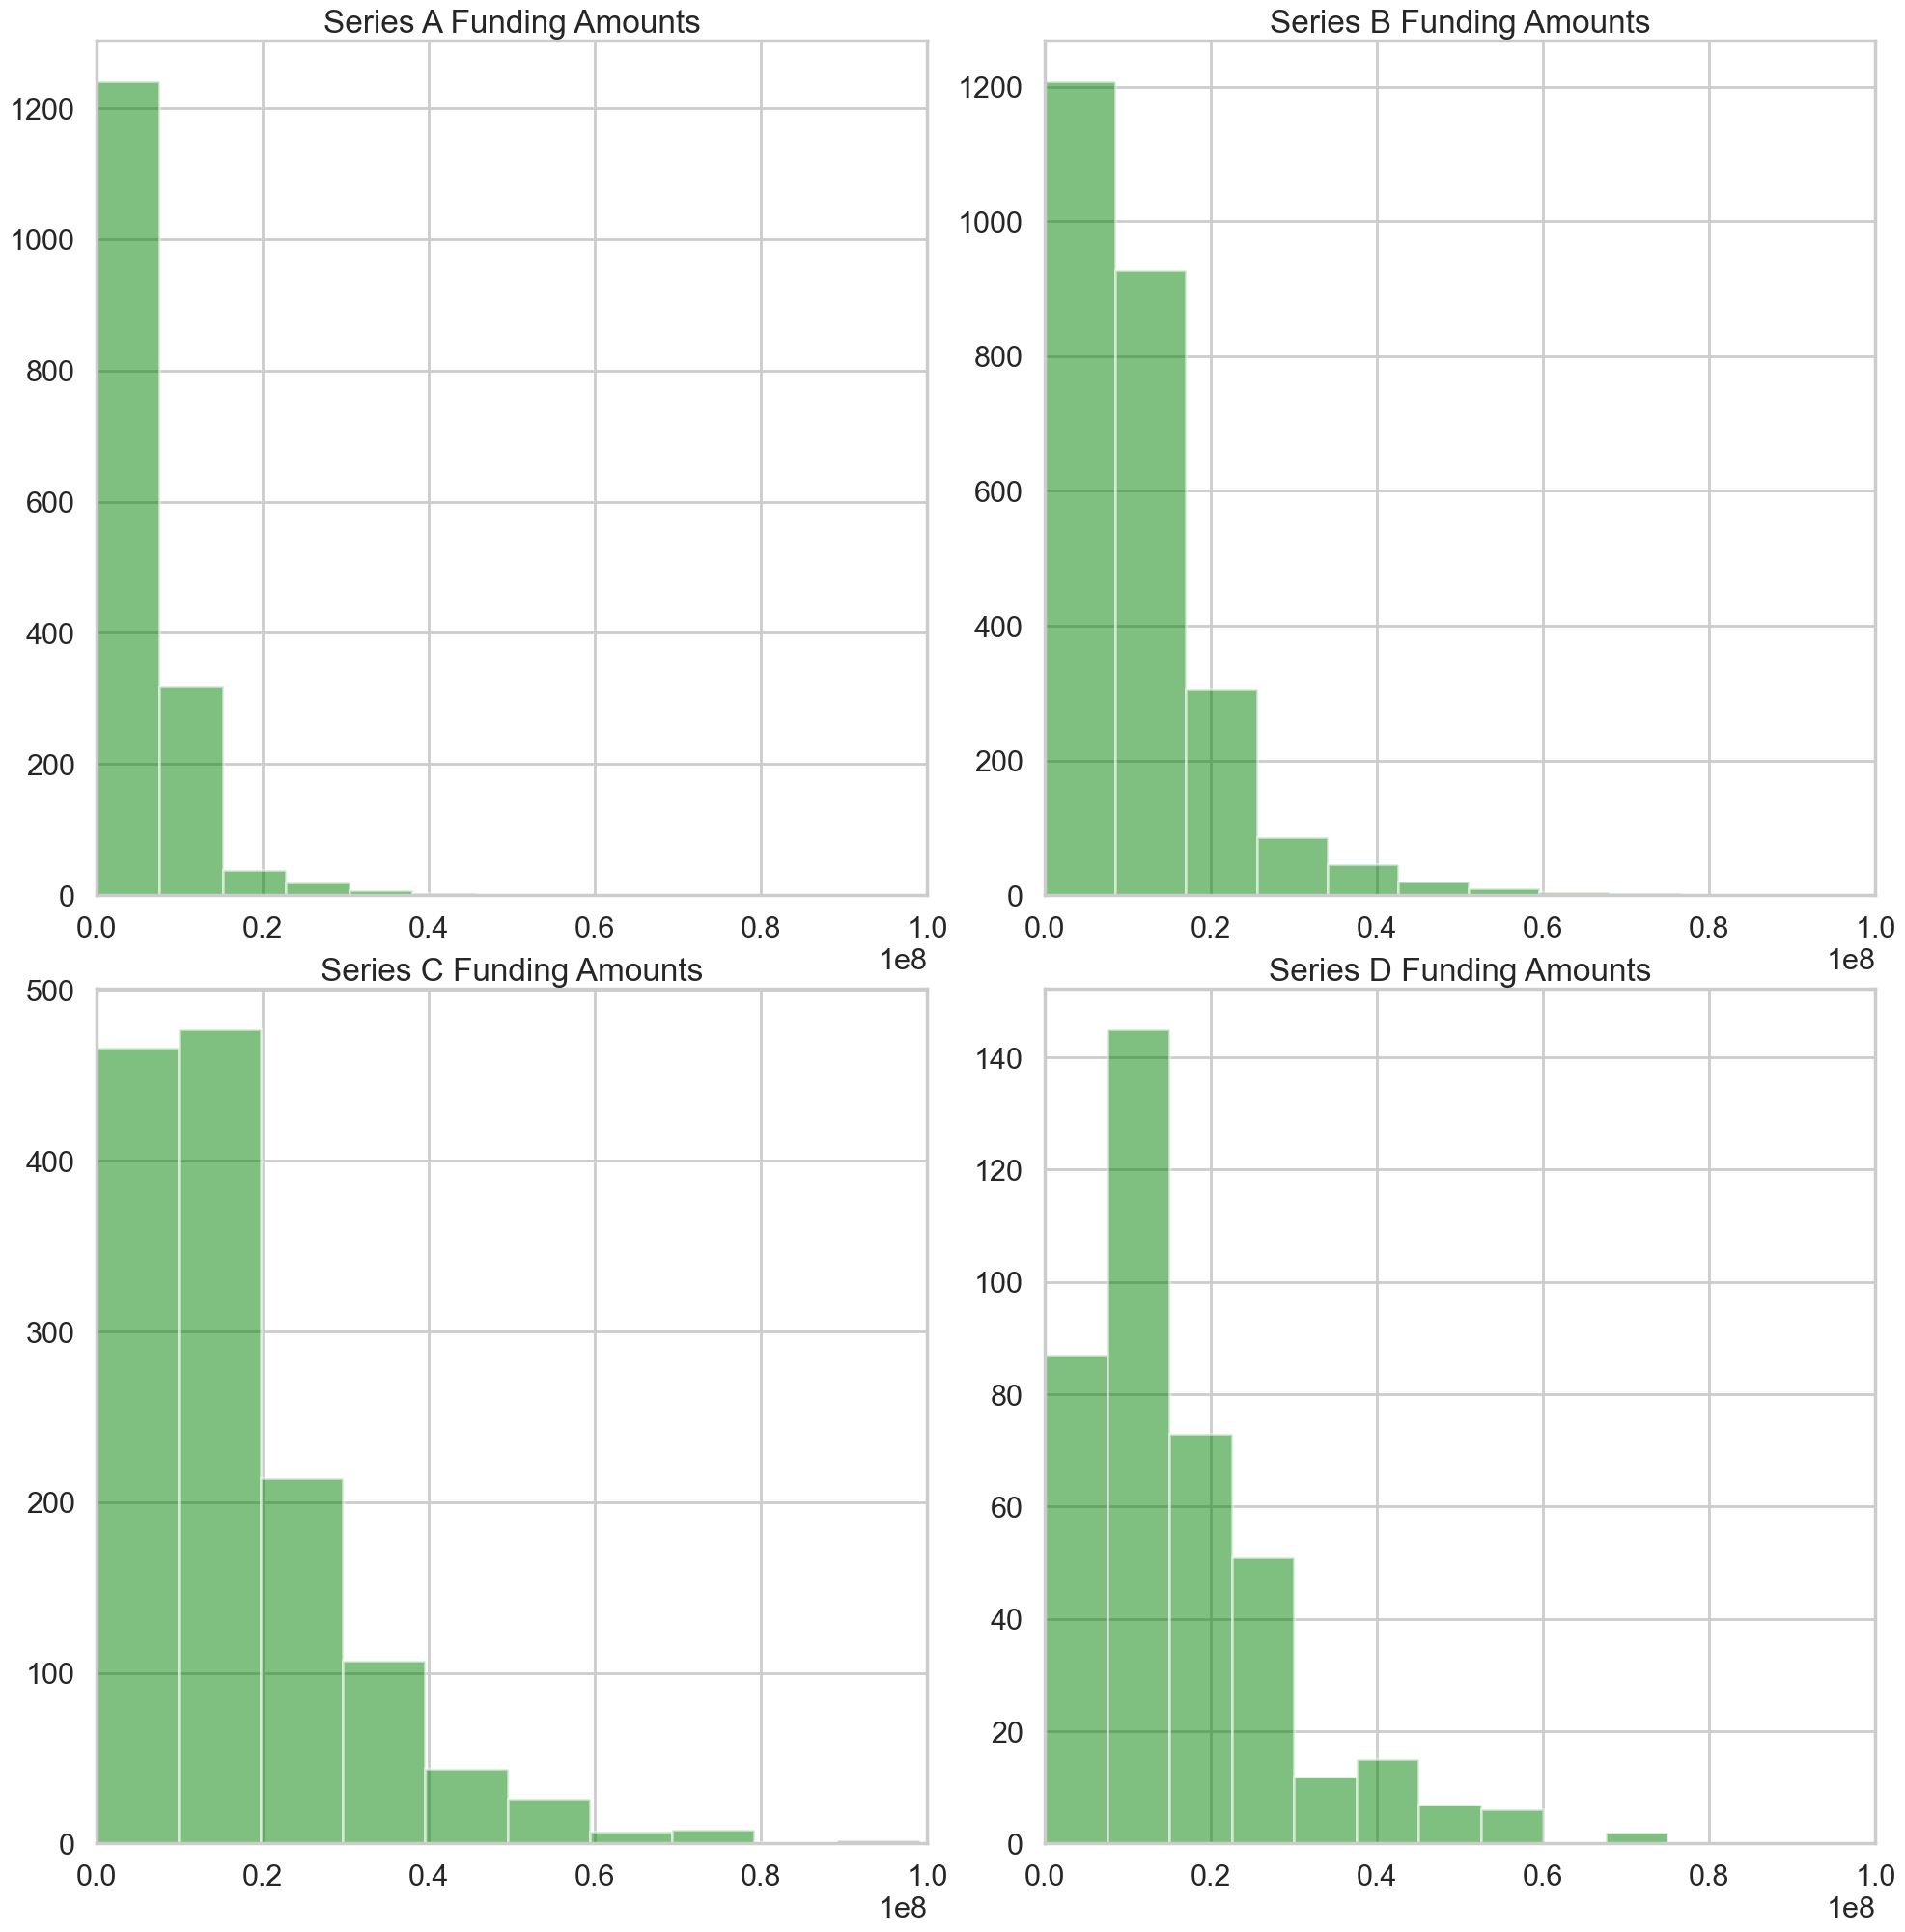

In [105]:
def creating_plots(funding_data_df):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))# Create a figure with two subplots sharing the x-axis
    fig.tight_layout()
    round_title = ['Series A Funding Amounts', 'Series B Funding Amounts', 'Series C Funding Amounts', 'Series D Funding Amounts']
    rounds = [funding_data_df.Series_A_Amount, funding_data_df.Series_B_Amount, funding_data_df.Series_C_Amount, funding_data_df.Series_D_Amount]
    for ax, i in zip(axes.ravel(), range(len(rounds))):
        funding = rounds[i] 
        amounts = filter(lambda x: x!='', list(funding))
        amounts = list(map(lambda x: int(x[1:].replace(',', '')), amounts))
        ax.hist(amounts, color='green', alpha=0.5)
        ax.set_title(round_title[i])
        ax.set_xlim(0, 1e8)

creating_plots(funding_data_df)

In [106]:
def creating_plots_log(funding_data_df):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
    fig.tight_layout()
    round_title = ['Series A Funding Amounts', 'Series B Funding Amounts', 'Series C Funding Amounts', 'Series D Funding Amounts']
    rounds = [funding_data_df.Series_A_Amount, funding_data_df.Series_B_Amount, funding_data_df.Series_C_Amount, funding_data_df.Series_D_Amount]
    for ax, i in zip(axes.ravel(), range(len(rounds))):
        funding = rounds[i] 
        amounts = filter(lambda x: x!='', list(funding))
        amounts = list(map(lambda x: int(x[1:].replace(',', '')), amounts))
        ax.hist(np.log(amounts), color='green', alpha=0.5)
        ax.set_title(round_title[i])

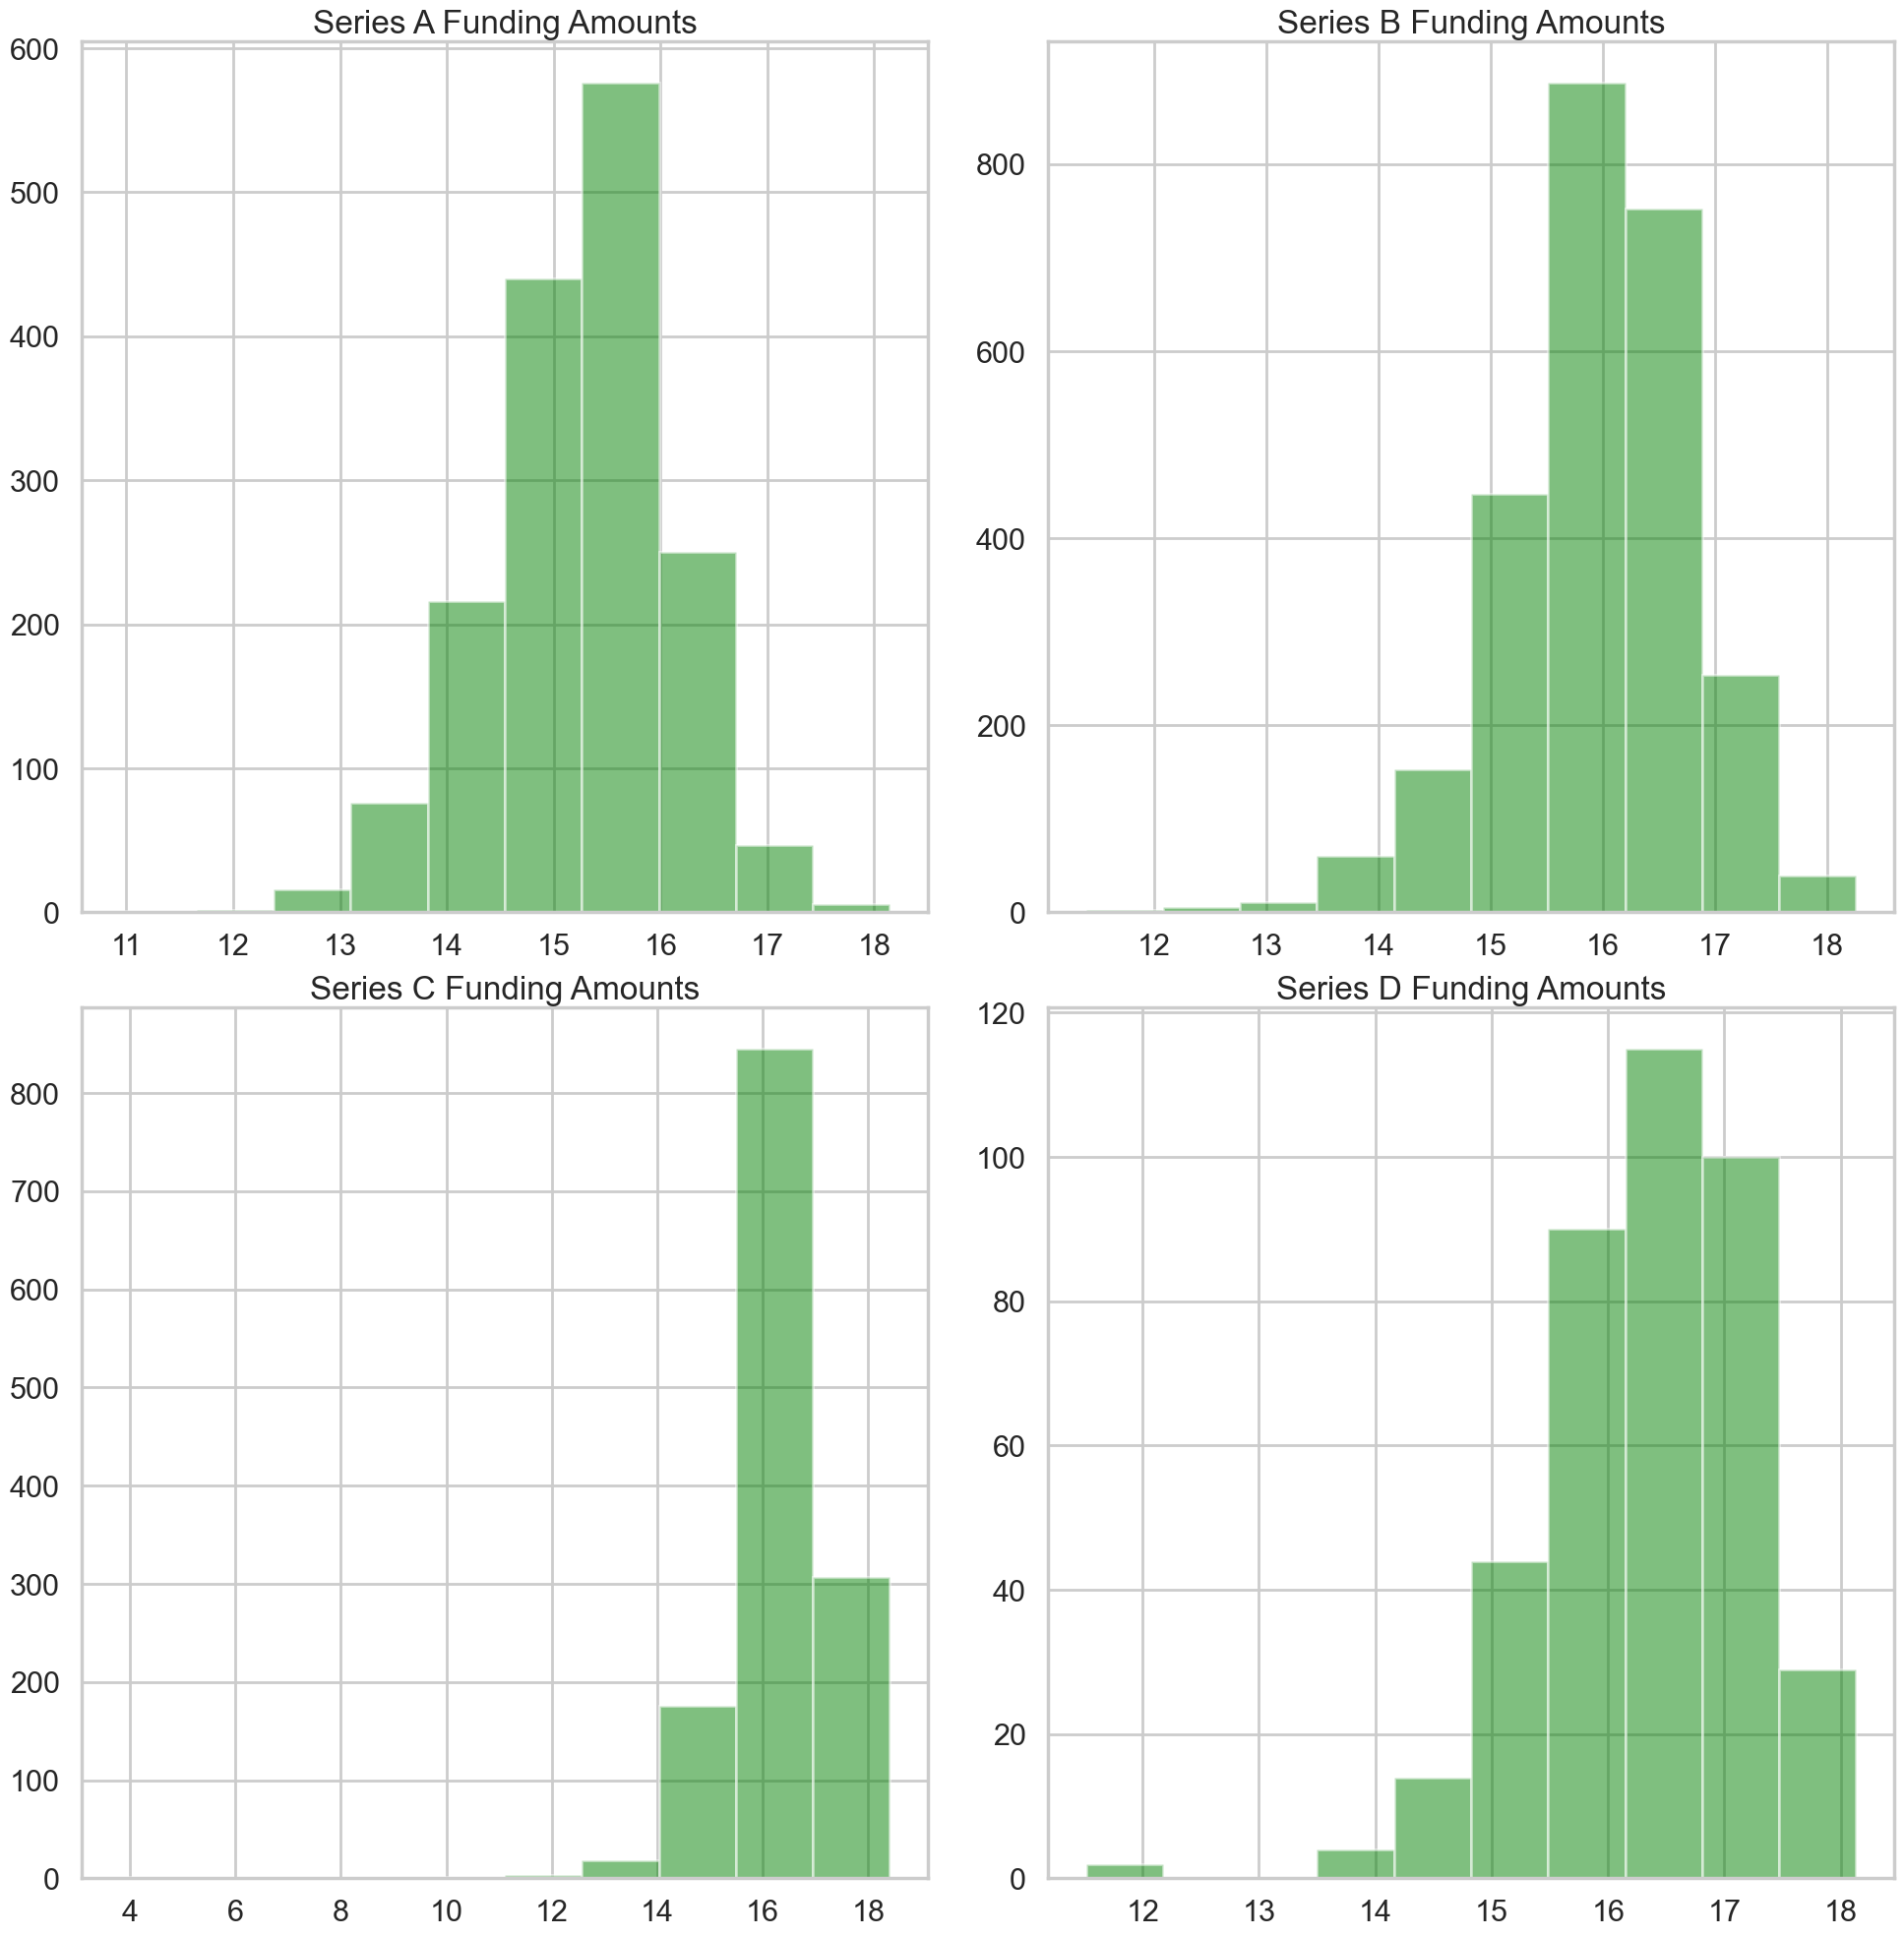

In [107]:
creating_plots_log(funding_data_df)

# Naive Bayes Prediction

In [108]:
series_A = funding_data_df[funding_data_df['Series_A_Amount'] != ''][['Names', 'Series_A_Amount', 'Market']]
series_A.columns = ['Names', 'Series_Amount', 'Market']
series_A['Series_Type'] = pd.Series('Series_A', index=series_A.index)

series_B = funding_data_df[funding_data_df['Series_B_Amount'] != ''][['Names', 'Series_B_Amount', 'Market']]
series_B.columns = ['Names', 'Series_Amount', 'Market']
series_B['Series_Type'] = pd.Series('Series_B', index=series_B.index)

series_C = funding_data_df[funding_data_df['Series_C_Amount'] != ''][['Names', 'Series_C_Amount', 'Market']]
series_C.columns = ['Names', 'Series_Amount', 'Market']
series_C['Series_Type'] = pd.Series('Series_C', index=series_C.index)

series_D = funding_data_df[funding_data_df['Series_D_Amount'] != ''][['Names', 'Series_D_Amount', 'Market']]
series_D.columns = ['Names', 'Series_Amount', 'Market']
series_D['Series_Type'] = pd.Series('Series_D', index=series_D.index)

funding_collapsed = pd.concat([series_A, series_B, series_C, series_D])
funding_collapsed.head()

,Names,Series_Amount,Market,Series_Type
2,Visualead,"$1,600,000",Bridging Online and Offline,Series_A
5,filmloop,"$5,600,000",Software,Series_A
6,Mochi-Media,"$4,000,000",,Series_A
7,SkyRecon-Systems,"$3,730,000",-,Series_A
8,Lumos-Labs,"$3,100,000",,Series_A


In [109]:
from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(funding_collapsed.shape[0]), train_size=0.7)
mask=np.ones(funding_collapsed.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask=(mask==1)
funding_train = funding_collapsed[mask]
funding_test = funding_collapsed[~mask]
funding_train.head()

,Names,Series_Amount,Market,Series_Type
2,Visualead,"$1,600,000",Bridging Online and Offline,Series_A
6,Mochi-Media,"$4,000,000",,Series_A
7,SkyRecon-Systems,"$3,730,000",-,Series_A
9,ROBLOX,"$2,200,000",Blockchains,Series_A
11,Health-Guru-Media,"$250,000",Colleges,Series_A


In [110]:
def rmse(testdf):
#     print( testdf)# testdf = testdf.drop(['id'], axis=1)
#     print(list(map(lambda pred, actual: (pred-actual)**2, testdf['Predicted_Amount'], testdf['Series_Amount'])))
#     print(np.mean(list(map(lambda pred, actual: (pred-actual)**2, testdf['Predicted_Amount'], testdf['Series_Amount']))))
#     print(np.sqrt(np.mean(list(map(lambda pred, actual: (pred-actual)**2, testdf['Predicted_Amount'], testdf['Series_Amount'])))))
    return (np.sqrt(np.mean(list(map(lambda pred, actual: (pred-actual)**2, testdf['Predicted_Amount'], testdf['Series_Amount'])))))/100000
    

In [111]:

funding_test['Series_Amount'] = funding_test['Series_Amount'].str.replace(',', '')
funding_test['Series_Amount'] = funding_test['Series_Amount'].str.replace('$', '')
funding_test['Series_Amount'] = funding_test['Series_Amount'].astype(int)
# fd = [funding_train['Series_Type'] == 'Series_A']
# type(funding_train[funding_train['Names']=='Visualead'].Series_Amount)
#     series_b_avg = finding_statistics(funding_train[funding_train['Series_Type'] == 'Series_B'].Series_Amount)[0]
                                     
funding_test

C:\Users\MY PC\AppData\Local\Temp\ipykernel_3164\3149657602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funding_test['Series_Amount'] = funding_test['Series_Amount'].str.replace(',', '')
C:\Users\MY PC\AppData\Local\Temp\ipykernel_3164\3149657602.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  funding_test['Series_Amount'] = funding_test['Series_Amount'].str.replace('$', '')
C:\Users\MY PC\AppData\Local\Temp\ipykernel_3164\3149657602.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,Names,Series_Amount,Market,Series_Type
5,filmloop,5600000,Software,Series_A
8,Lumos-Labs,3100000,,Series_A
10,SendHub,3000000,B2B,Series_A
14,Forus-Health,5000000,Mobile Analytics,Series_A
20,Dailymotion,9500000,,Series_A
...,...,...,...,...
3122,Adometry,8100000,News,Series_D
3148,Conformia-Software,3000000,Biotechnology,Series_D
3151,Appirio,60000000,,Series_D
3172,Transera-Communications,17000000,Software,Series_D


In [112]:
#series_a_avg = np.mean(funding_test[funding_test['Series_Type'] == 'Series_A'].Series_Amount).astype(int)
#series_a_avg
series_a_avg = np.mean(funding_test[funding_test['Series_Type'] == 'Series_A'].Series_Amount)
print(int(series_a_avg))  # cast to integer when printing if needed


6076137


In [113]:
def return_series_avg(stage):
    series_a_avg = np.mean(funding_test[funding_test['Series_Type'] == 'Series_A'].Series_Amount)
    series_b_avg = np.mean(funding_test[funding_test['Series_Type'] == 'Series_B'].Series_Amount)
    series_c_avg = np.mean(funding_test[funding_test['Series_Type'] == 'Series_C'].Series_Amount)
    series_d_avg = np.mean(funding_test[funding_test['Series_Type'] == 'Series_D'].Series_Amount)
    if stage == 'Series_A':
        return series_a_avg
    elif stage == 'Series_B':
        return series_b_avg
    elif stage == 'Series_C':
        return series_c_avg 
    elif stage == 'Series_D':
        return series_d_avg
    else:
        return 1
funding_test['Predicted_Amount']=[return_series_avg(x) for x in funding_test['Series_Type']]
funding_test

C:\Users\MY PC\AppData\Local\Temp\ipykernel_3164\3632562599.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funding_test['Predicted_Amount']=[return_series_avg(x) for x in funding_test['Series_Type']]


,Names,Series_Amount,Market,Series_Type,Predicted_Amount
5,filmloop,5600000,Software,Series_A,6.076138e+06
8,Lumos-Labs,3100000,,Series_A,6.076138e+06
10,SendHub,3000000,B2B,Series_A,6.076138e+06
14,Forus-Health,5000000,Mobile Analytics,Series_A,6.076138e+06
20,Dailymotion,9500000,,Series_A,6.076138e+06
...,...,...,...,...,...
3122,Adometry,8100000,News,Series_D,1.732805e+07
3148,Conformia-Software,3000000,Biotechnology,Series_D,1.732805e+07
3151,Appirio,60000000,,Series_D,1.732805e+07
3172,Transera-Communications,17000000,Software,Series_D,1.732805e+07


In [114]:
funding_test

,Names,Series_Amount,Market,Series_Type,Predicted_Amount
5,filmloop,5600000,Software,Series_A,6.076138e+06
8,Lumos-Labs,3100000,,Series_A,6.076138e+06
10,SendHub,3000000,B2B,Series_A,6.076138e+06
14,Forus-Health,5000000,Mobile Analytics,Series_A,6.076138e+06
20,Dailymotion,9500000,,Series_A,6.076138e+06
...,...,...,...,...,...
3122,Adometry,8100000,News,Series_D,1.732805e+07
3148,Conformia-Software,3000000,Biotechnology,Series_D,1.732805e+07
3151,Appirio,60000000,,Series_D,1.732805e+07
3172,Transera-Communications,17000000,Software,Series_D,1.732805e+07


In [115]:
import re
# Preprocess the text
funding_test['Names'] = funding_test['Names'].apply(lambda x: x.lower())
funding_test['Names'] = funding_test['Names'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
funding_test = funding_test.rename(columns={'Names': 'Company'})
funding_test.head()

data = funding_test[['Company','Series_Type']]
unique_data = data.drop_duplicates().dropna(subset=['Series_Type'])

unique_data.to_csv('Company_Series.csv', index=False)


C:\Users\MY PC\AppData\Local\Temp\ipykernel_3164\292826020.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funding_test['Names'] = funding_test['Names'].apply(lambda x: x.lower())
C:\Users\MY PC\AppData\Local\Temp\ipykernel_3164\292826020.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funding_test['Names'] = funding_test['Names'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
